In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
from scipy.interpolate import interp2d

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

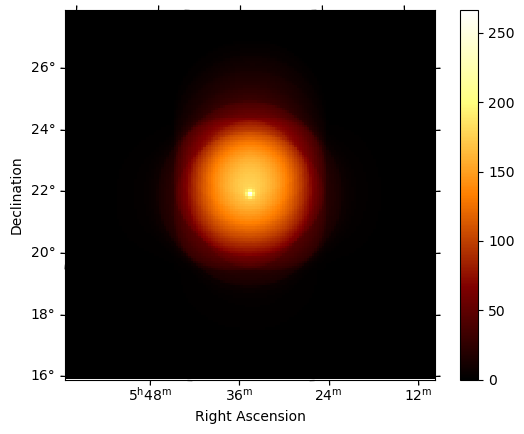

In [3]:
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 
model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )

# Create the spectral model 
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",
    lambda_="0.1 TeV-1")

# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

# set the models in the dataset
dataset_asimov.models = models
# set counts
dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

In [4]:
def compute_fraction(Ls_new, x_new,
               y_new, threshold, plot = False):
    tot_int = np.sum(Ls_new)
    offset = Ls_new.min() + threshold
    outside = Ls_new* (Ls_new < offset)
    inside = Ls_new* (Ls_new >= offset)
    fraction_inside = np.sum(inside)/ tot_int
    fraction=  (tot_int - np.sum(outside))/ tot_int 
    if plot:
        fig,ax = plt.subplots(1,1, )
        im =ax.pcolormesh(x_new,
               y_new,
               Ls_new)
        fig.colorbar(im);
        ax.set_title(f"frac inside : {fraction_inside * 100:.4} %")

        CS = ax.contour(x_new,
               y_new,Ls_new, colors=('gold',), levels = [Ls_new.min() + threshold])    
    return fraction_inside

def plot_L(Ls_new, x_new, y_new, threshold, find_min = True, color = 'red'):
    index_min, index_max,  ampli_min,  ampli_max, index_best, ampli_best = compute_errors(
        Ls_new, x_new, y_new, threshold, find_min = find_min )
    fig,ax = plt.subplots(1,1, )
    im =ax.pcolormesh(x_new,
       y_new,
       Ls_new)
    fig.colorbar(im);

    CS = ax.contour(x_new,
       y_new,Ls_new, colors=('gold',), levels = [ Ls_new.min() + threshold]) 
    linewidth = 2
    ax.hlines(y = index_min, xmin = x_new[0], xmax = x_new[-1], color = color,
             linestyle = 'dotted', linewidth = linewidth)
    ax.hlines(y = index_max, xmin = x_new[0], xmax = x_new[-1], color = color,
             linestyle = 'dotted', linewidth = linewidth)

    ax.vlines(x = ampli_min, ymin = y_new[0], ymax = y_new[-1], color = color,
             linestyle = 'dotted', linewidth = linewidth)
    ax.vlines(x = ampli_max, ymin = y_new[0], ymax = y_new[-1], color = color,
             linestyle = 'dotted', linewidth = linewidth)

    ax.plot(ampli_best, index_best, 'x')

    plt.ylabel("amplitude")
    plt.xlabel("index")
    return CS
    
    
def compute_errors(Ls_new, x_new,
               y_new, threshold , find_min = False):
    tot_int = np.sum(Ls_new)
    offset = Ls_new.min() + threshold
    outside = Ls_new* (Ls_new < offset)
    inside = Ls_new* (Ls_new >= offset)
    if find_min: # find min:
        pos = np.where(inside >= 0 )
        ampli_best = x_new[np.where(Ls_new == Ls_new.min())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.min())[0][0]]
        
    else:  # find max
        pos = np.where(inside > 0 )
        ampli_best = x_new[np.where(Ls_new == Ls_new.max())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.max())[0][0]]
        
    delta_bin = (x_new[1] - x_new[0] )/2
    ampli_min = x_new[np.min(pos[1])]-delta_bin
    ampli_max = x_new[np.max(pos[1])]+delta_bin
    ampli_best += delta_bin
    
    delta_bin = (y_new[1] - y_new[0] )/2
    index_min = y_new[np.min(pos[0])]-delta_bin
    index_max = y_new[np.max(pos[0])]+delta_bin
    index_best += delta_bin
    
    print(ampli_best, index_best)
    return index_min, index_max,  ampli_min,  ampli_max, index_best, ampli_best
    

## Varying the Exposure

In [5]:
savefig = False
shift = 0.1 #0.085
tilt = 0.015

In [6]:
infos = np.loadtxt("data/7a_P_draw_info.txt")
pars = np.loadtxt("data/7a_P_draw_par.txt")
flux = np.loadtxt("data/7a_P_draw_flux.txt")
flux2e = np.loadtxt("data/7a_P_draw_flux2e.txt")


lem = len(infos)
N_max = 1000
N = np.min([lem, N_max])

print(N)

shift_rnds = infos[:N_max,0]
index_rnds = infos[:N_max,1]
stat_sums = infos[:N_max,2]


#amplitude', 'index', 'norm', 'tilt
amplitudes = pars[:N_max,0:2] 
indices = pars[:N_max,2:4] 
norms = pars[:N_max,4:6]
tilts = pars[:N_max,6:8]

valuies = [norms, amplitudes, indices]

800


In [7]:
sys_ = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0, 
                        tilt = 0,
                        rnd = False)
dataset_asimov = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N()

zero = 1e-24
## additional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/shift**2, 1/tilt**2, 1/zero**2, 1/zero**2])
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix


fit_cor = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_cor.backend = "minuit"
fit_cor.optimize_opts = minuit_opts
result_cor = fit_cor.run([dataset_asimov])    
result_cor = fit_cor.run([dataset_asimov_N]) 

In [8]:
valuies_asimov = [[dataset_asimov.models[1].parameters['norm'].value, 
                   dataset_asimov.models[1].parameters['norm'].error],
                  [dataset_asimov.models[0].parameters['amplitude'].value, 
                   dataset_asimov.models[0].parameters['amplitude'].error],
                  [dataset_asimov.models[0].parameters['index'].value, 
                   dataset_asimov.models[0].parameters['index'].error],]


valuies_asimov_N = [[dataset_asimov_N.models[1].parameters['norm'].value, 
                   dataset_asimov_N.models[1].parameters['norm'].error],
                  [dataset_asimov_N.models[0].parameters['amplitude'].value, 
                   dataset_asimov_N.models[0].parameters['amplitude'].error],
                  [dataset_asimov_N.models[0].parameters['index'].value, 
                   dataset_asimov_N.models[0].parameters['index'].error],]

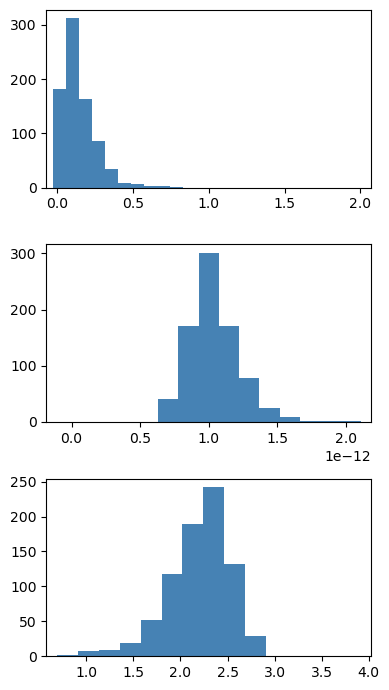

In [9]:
fig, axs = plt.subplots(3,1, figsize = (4,7))
xlabels = ["Best Fit BKG Norm", "Best Fit Amplitude", "Best Fit Index"]

for i, v in enumerate(valuies):
    axs[i].hist(v[1:,0], color ='steelblue')
    
    x = axs[i].get_xlim()
    deltax = np.max([ valuies_asimov[i][0] - x[0] , x[1] - valuies_asimov[i][0] ])
    axs[i].set_xlim(valuies_asimov[i][0] -deltax, 
                    valuies_asimov[i][0] + deltax)
    
plt.tight_layout()

## Asimov Likelihood

In [10]:
%%time
computing = True
if computing:

    x = dataset_asimov.models.parameters['amplitude']
    y = dataset_asimov.models.parameters['index']
    x.scan_n_sigma = 5
    y.scan_n_sigma = 2
    x.scan_n_values = 21
    y.scan_n_values = 20

    contour = fit_cor.stat_surface([dataset_asimov], x, y, reoptimize=True) 

    contour_write = dict()
    for k in contour.keys():
        print(k)
        if k != 'fit_results':
            contour_write[k]  = contour[k].tolist()
            
    with open('data/7c_contour.yml' , 'w') as outfile:
        yaml.dump(contour_write, outfile, default_flow_style=False)
        
else:
    with open('data/7c_contour.yml', 'r') as stream:
        contour=yaml.safe_load(stream)
        
amplix__ = contour['Source.spectral.amplitude_scan']
indexy__ = contour['Source.spectral.index_scan']
N_new = 110
N_new_y = 110
amplix__new =  np.linspace(amplix__[0], amplix__[-1],N_new)
indexy__new =  np.linspace(indexy__[0], indexy__[-1],N_new_y)


f = interp2d(x = indexy__, y= amplix__, z = contour['stat_scan'], kind='cubic',fill_value = None, bounds_error = False )
data_contour = f(indexy__new, amplix__new)



Source.spectral.amplitude_scan
Source.spectral.index_scan
stat_scan
fit_results
CPU times: total: 11min 30s
Wall time: 11min 36s


min index: 2.2957877801623816
min amplitude: 1.0056966106017763e-12


Text(0.5, 1.0, 'Likelihood')

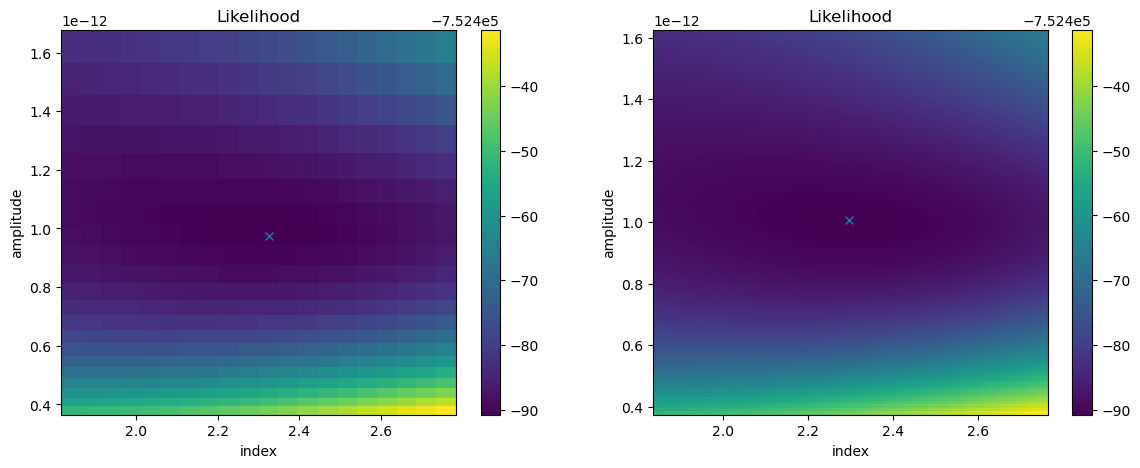

In [11]:
fig, (ax1, ax) = plt.subplots(1,2, figsize = (14,5))


im =ax1.pcolormesh(indexy__, amplix__, contour['stat_scan'])
dddd = np.array(contour['stat_scan'])
ampli_best = amplix__[np.where(dddd == dddd.min())[0][0]]
index_best = indexy__[np.where(dddd == dddd.min())[1][0]]

ax1.plot(index_best, ampli_best, 'x')
fig.colorbar(im, ax=ax1)
ax1.set_ylabel("amplitude")
ax1.set_xlabel("index",)
ax1.set_title(f"Likelihood")


im =ax.pcolormesh(indexy__new, amplix__new, data_contour)
dddd = np.array(data_contour)
ampli_best = amplix__new[np.where(dddd == dddd.min())[0][0]]
index_best = indexy__new[np.where(dddd == dddd.min())[1][0]]
print("min index:", index_best)
print("min amplitude:", ampli_best)

ax.plot(index_best, ampli_best, 'x')
fig.colorbar(im, ax=ax)
ax.set_ylabel("amplitude")
ax.set_xlabel("index",)
ax.set_title(f"Likelihood")

2.299999999536664 1.011393220836514e-12
2.299999999536664 1.011393220836514e-12


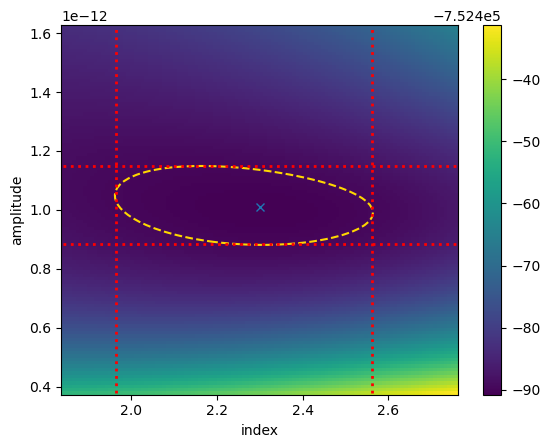

In [12]:
threshold_contour = 1
ampli_min_asimov,  ampli_max_asimov, index_min_asimov, index_max_asimov,  ampli_best_asimov, index_best_asimov = compute_errors(
    data_contour, indexy__new, amplix__new,  threshold_contour, find_min = True)

CS= plot_L(data_contour, indexy__new, amplix__new,  threshold_contour,
      find_min = True, color = 'red')

dat= CS.allsegs[0][0]

## Asimov Likelihood N

In [13]:
%%time
if computing:
    x_N = dataset_asimov_N.models.parameters['amplitude']
    y_N = dataset_asimov_N.models.parameters['index']

    x_N.scan_values = x.scan_values
    y_N.scan_values = y.scan_values

    contour_N = fit_cor.stat_surface([dataset_asimov_N], x_N, y_N, reoptimize=True ) 


    contour_write = dict()
    for k in contour_N.keys():
        print(k)
        if k != 'fit_results':
            contour_write[k]  = contour_N[k].tolist()
            
    with open('data/7c_contour_N.yml' , 'w') as outfile:
        yaml.dump(contour_write, outfile, default_flow_style=False)
        
else:
    with open('data/7c_contour_N.yml', 'r') as stream:
        contour_N=yaml.safe_load(stream)
        

amplix___N = contour_N['SourceN.spectral.amplitude_scan']
indexy___N = contour_N['SourceN.spectral.index_scan']
amplix__new_N =  np.linspace(amplix___N[0], amplix___N[-1],N_new)
indexy__new_N =  np.linspace(indexy___N[0], indexy___N[-1],N_new_y)    
        

f = interp2d(x = indexy___N, y= amplix___N, z = contour_N['stat_scan'], kind='cubic',fill_value = None, bounds_error = False )
data_contour_N = f(indexy__new_N, amplix__new_N)

KeyboardInterrupt: 

NameError: name 'indexy___N' is not defined

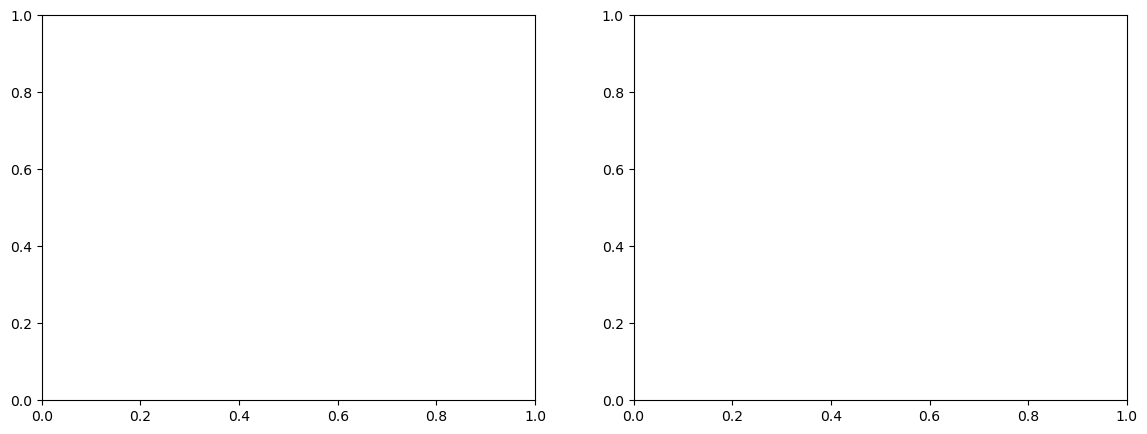

In [14]:
fig, (ax1, ax) = plt.subplots(1,2, figsize = (14,5))

im =ax1.pcolormesh(indexy___N, amplix___N, contour_N['stat_scan'])
dddd = np.array(contour_N['stat_scan'])
ampli_best_N = amplix___N[np.where(dddd == dddd.min())[0][0]]
index_best_N = indexy___N[np.where(dddd == dddd.min())[1][0]]

ax1.plot(index_best_N, ampli_best_N, 'x')
fig.colorbar(im, ax=ax1)
ax1.set_ylabel("amplitude")
ax1.set_xlabel("index",)
ax1.set_title(f"Likelihood")


im =ax.pcolormesh(indexy__new_N, amplix__new_N, data_contour_N)
dddd = np.array(data_contour_N)
ampli_best_N = amplix__new_N[np.where(dddd == dddd.min())[0][0]]
index_best_N = indexy__new_N[np.where(dddd == dddd.min())[1][0]]
print("min index:", index_best_N)
print("min amplitude:", ampli_best_N)

ax.plot(index_best_N, ampli_best_N, 'x')
fig.colorbar(im, ax=ax)
ax.set_ylabel("amplitude")
ax.set_xlabel("index",)
ax.set_title(f"Likelihood")

In [ ]:
ampli_min_asimov_N,  ampli_max_asimov_N, index_min_asimov_N, index_max_asimov_N, ampli_best_asimov_N, index_best_asimov_N = compute_errors(
    data_contour_N, indexy__new_N, amplix__new_N,  threshold_contour, find_min = True)

CS_N= plot_L(data_contour_N, indexy__new_N, amplix__new_N,  threshold_contour,
      find_min = True, color = 'green')

dat_N = CS_N.allsegs[0][0]
plt.plot(dat[:,0],dat[:,1], color = 'red')
plt.plot(index_best_N, ampli_best_N, 'x', color = 'green')
plt.plot(index_best, ampli_best, 'x', color = 'red')

## Compute fraction of within

In [ ]:
def fraction_within(lower_lim, upper_lim, data):
    is_within = []
    for d in data:
        larger = np.all(d[0] >= lower_lim )
        smaller = np.all(d[0] <= upper_lim)
        is_within.append(larger and smaller)
        
    return (np.count_nonzero(is_within) / len(data))
    

In [ ]:
# std best fit, nui best fit, ... 
within_norm = [fraction_within(valuies_asimov[0][0] - valuies_asimov[0][1],
                               valuies_asimov[0][0] +  valuies_asimov[0][1],
                               norms
                              ),
               fraction_within(valuies_asimov_N[0][0] - valuies_asimov_N[0][1],
                               valuies_asimov_N[0][0] + valuies_asimov_N[0][1],
                               norms
                              ),
               0., 0.,
              ]

within_amplitude = [fraction_within(valuies_asimov[1][0] - valuies_asimov[1][1],
                               valuies_asimov[1][0] +  valuies_asimov[1][1],
                               amplitudes
                              ),
               fraction_within(valuies_asimov_N[1][0] - valuies_asimov_N[1][1],
                               valuies_asimov_N[1][0] + valuies_asimov_N[1][1],
                               amplitudes
                              ),
               fraction_within(ampli_min_asimov,
                               ampli_max_asimov,
                               amplitudes
                              ),
                fraction_within(ampli_min_asimov_N,
                               ampli_max_asimov_N,
                               amplitudes
                              ),
                ]

within_index = [fraction_within(valuies_asimov[2][0] - valuies_asimov[2][1],
                               valuies_asimov[2][0] +  valuies_asimov[2][1],
                               indices
                              ),
               fraction_within(valuies_asimov_N[2][0] - valuies_asimov_N[2][1],
                               valuies_asimov_N[2][0] + valuies_asimov_N[2][1],
                               indices
                              ),
                fraction_within(index_min_asimov,
                               index_max_asimov,
                               indices
                              ),
                fraction_within(index_min_asimov_N,
                               index_max_asimov_N,
                               indices
                              ),]

withins = [within_norm, 
          within_amplitude,
          within_index]
print(withins)

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (4,7))
xlabels = ["Best Fit BKG Norm", "Best Fit Amplitude", "Best Fit Index"]
legends = ["Nuisance",'Standard',   ]

for i, v in enumerate(valuies):
    print(i, xlabels[i])
    axs[i].hist(v[1:,0], color ='steelblue', alpha = 0.8)
    ylim = axs[i].get_ylim()
    delta_ylim = 5
    
    axs[i].vlines(valuies_asimov_N[i][0], ylim[0], ylim[1]+ delta_ylim, color = 'green', 
                 linestyle= 'dashed', )
    axs[i].fill_between([valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
                         valuies_asimov_N[i][0] + valuies_asimov_N[i][1]]
                        , ylim[0], ylim[1]+ delta_ylim,
                       alpha = 0.3, color = 'green', 
                        label = legends[0] + f' \n({withins[i][1]*100 :.3}%)')
    axs[i].vlines(valuies_asimov[i][0], ylim[0], ylim[1], color = 'red')
    axs[i].fill_between([valuies_asimov[i][0] - valuies_asimov[i][1],
                         valuies_asimov[i][0] + valuies_asimov[i][1]]
                        , ylim[0], ylim[1],
                       alpha = 0.4 , color = 'red', 
                        label = legends[1] +  f' \n({withins[i][0]*100 :.3}%)'  )
    
    axs[i].set_xlabel(xlabels[i])  
    
    
    x = axs[i].get_xlim()
    deltax = np.max([ valuies_asimov[i][0] - x[0] , x[1] - valuies_asimov[i][0] ])
    axs[i].set_xlim(valuies_asimov[i][0] -deltax, 
                    valuies_asimov[i][0] + deltax)
    
ylim = axs[1].get_ylim()
delta_ylim = 9  
axs[1].vlines(ampli_min_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green',  linestyle = 'dashed') 
axs[1].vlines(ampli_max_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green',  linestyle = 'dashed',
             label=f'({withins[1][3]*100:.3} %)')    
axs[1].vlines(ampli_best_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green',
              linestyle = 'dotted')

delta_ylim = 2
axs[1].vlines(ampli_min_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red',  linestyle = 'dashed') 
axs[1].vlines(ampli_max_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red',  linestyle = 'dashed',
             label=f'({withins[1][2]*100:.3} %)')    
axs[1].vlines(ampli_best_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red',
              linestyle = 'dotted')

ylim = axs[2].get_ylim()
delta_ylim = 9

axs[2].vlines(index_min_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green', linestyle = 'dashed') 
axs[2].vlines(index_max_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green', linestyle = 'dashed',
             label=f'({withins[2][3]*100:.3} %)')   
axs[2].vlines(index_best_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green',
              linestyle = 'dotted')
delta_ylim = 2
axs[2].vlines(index_min_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red', linestyle = 'dashed') 
axs[2].vlines(index_max_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red', linestyle = 'dashed',
             label=f'({withins[2][2]*100:.3} %)') 
axs[2].vlines(index_best_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red',
              linestyle = 'dotted')
plt.tight_layout()
for a in axs:
    a.legend(title="1$\sigma$ eror",loc='center left', bbox_to_anchor=(1, 0.5))



## 2D Histograms Poission

In [ ]:
N_bins = N_new + 1
amplitude_bin = np.linspace(amplix__new_N[0], amplix__new_N[-1], N_bins )
index_bin = np.linspace(indexy__new_N[0], indexy__new_N[-1], N_bins )

amplitudes_data = valuies[1][:,0]
indices_data = valuies[2][:,0]
data_N_new, (abins, ibins) = np.histogramdd((amplitudes_data, indices_data), (amplitude_bin, index_bin))

fig, ax = plt.subplots()
im =ax.pcolormesh(ibins, 
           abins,
           data_N_new)

fig.colorbar(im, ax=ax)
ax.plot(index_best_N, ampli_best_N, 'x', color = 'green')
ax.plot(index_best, ampli_best, 'x', color = 'red')

ax.set_ylabel("Amplitudes")
ax.set_xlabel("Indices")
plt.plot(dat[:,0],dat[:,1], color = 'red')
plt.plot(dat_N[:,0],dat_N[:,1], color = 'green')

In [ ]:
def compute_inside(Ls_new, x_new,
               y_new, threshold,  find_min = False,  delta=1
                 ):
    tot_int = np.sum(Ls_new)
    offset = Ls_new.min() + threshold
    outside = Ls_new* (Ls_new < offset)
    inside = Ls_new* (Ls_new >= offset)

    return outside
    

In [ ]:
threshold_contour = 1
outside_N = compute_inside(
    data_contour_N, amplix__new_N,
           indexy__new_N,  threshold_contour,  find_min = True, delta =1 )

outside = compute_inside(
    data_contour, amplix__new_N,
           indexy__new_N, threshold_contour,  find_min = True, delta =1 )

outside_N = outside_N <-1.0
outside = outside <-1.0



In [ ]:
masked_N =  data_N_new * outside_N
masked =  data_N_new * outside

fig, (ax, ax2) = plt.subplots(1,2, figsize = (11,4))
im =ax.pcolormesh(indexy__new_N,
           amplix__new_N, masked)

fig.colorbar(im, ax=ax)
im =ax2.pcolormesh(indexy__new_N,
           amplix__new_N, masked_N)

fig.colorbar(im, ax=ax2)
for a in [ax, ax2]:
    a.set_ylabel("amplitude")
    a.set_xlabel("index",)
    a.plot(dat[:,0],dat[:,1], color = 'red')
    a.plot(dat_N[:,0],dat_N[:,1], color = 'green')

fraction_within_2d_N = np.sum(masked_N) /  np.sum(data_N_new)
fraction_within_2d = np.sum(masked) /  np.sum(data_N_new)

ax2.set_title(f"Likelihood Nuisance: {fraction_within_2d_N:.3}")
ax.set_title(f"Likelihood {fraction_within_2d:.3}")